In [15]:
# Cell 1 - imports & configuration
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from glob import glob
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Reproducible-ish
np.random.seed(42)
tf.random.set_seed(42)

# Config
DATA_DIR = r"C:\Users\ThinkPad\OneDrive\Documents\Portofolio\flower recognition\dataset"  # <-- ganti kalau perlu
IMG_SIZE = 224   # ukuran input untuk MobileNetV2
BATCH_SIZE = 32
SEED = 42
NUM_EPOCHS_HEAD = 10
NUM_EPOCHS_FINETUNE = 10
FINE_TUNE_AT = -50   # buka 50 layer terakhir dari backbone (negative index)
MODEL_SAVE_PATH = "best_model_transfer.keras"


In [10]:
# Cell 2 - inspect classes and counts
classes = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
classes = sorted(classes)
print("Classes found:", classes)

# count images per class
from collections import Counter
counts = {}
for c in classes:
    files = glob(os.path.join(DATA_DIR, c, "*.jpg")) + glob(os.path.join(DATA_DIR, c, "*.png"))
    counts[c] = len(files)
print("Counts per class:", counts)


Classes found: ['daisy', 'dandelion', 'rose']
Counts per class: {'daisy': 764, 'dandelion': 1052, 'rose': 362}


In [11]:
# Cell 3 - datagens
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8,1.2),
    validation_split=0.20  # split 20% for validation
)

# train generator (from directory)
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED,
    shuffle=True
)

# validation generator
val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    shuffle=False
)

num_classes = train_generator.num_classes
print("Num classes:", num_classes)


Found 1744 images belonging to 3 classes.
Found 434 images belonging to 3 classes.
Num classes: 3


In [12]:
# Cell 4 - compute class weights
# Need labels per sample (integers) from train_generator
train_labels = train_generator.classes  # integer labels per sample in the same order
class_weights_list = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = {i: w for i, w in enumerate(class_weights_list)}
print("Class weights:", class_weights)


Class weights: {0: 0.9498910675381264, 1: 0.6904196357878069, 2: 2.004597701149425}


In [13]:
# Cell 5 - build transfer learning model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze for head training

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
# Cell 6 - callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True, verbose=1)
]


In [17]:
# Cell 7 - train head
history_head = model.fit(
    train_generator,
    epochs=NUM_EPOCHS_HEAD,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10


c:\Haifa\Documents\Anaconda\envs\haifanisa\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5036 - loss: 1.2700
Epoch 1: val_loss improved from inf to 0.39602, saving model to best_model_transfer.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5049 - loss: 1.2660 - val_accuracy: 0.8594 - val_loss: 0.3960 - learning_rate: 1.0000e-04
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.7178 - loss: 0.6702
Epoch 2: val_loss improved from 0.39602 to 0.33094, saving model to best_model_transfer.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7182 - loss: 0.6691 - val_accuracy: 0.8456 - val_loss: 0.3309 - learning_rate: 1.0000e-04
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.7909 - loss: 0.5104
Epoch 3: val_loss improved from 0.33094 to 0.29756, saving model to best_model_transfer.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7908 - loss: 0.5107 - val_accuracy: 0.8687 - val_loss: 0.2976 - learning_rate: 1.0000e-04
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/st

In [18]:
# Cell 8 - unfreeze last layers and fine-tune
# Unfreeze last N layers of base_model
base_model.trainable = True

# freeze all layers up to last N
if FINE_TUNE_AT < 0:
    # convert negative index to positive
    N = -FINE_TUNE_AT
else:
    N = FINE_TUNE_AT

# keep all but last N layers frozen
for layer in base_model.layers[:-N]:
    layer.trainable = False

# recompile with lower LR
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    epochs=NUM_EPOCHS_HEAD + NUM_EPOCHS_FINETUNE,
    initial_epoch=history_head.epoch[-1] + 1 if hasattr(history_head, 'epoch') and len(history_head.epoch)>0 else NUM_EPOCHS_HEAD,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.7144 - loss: 0.6294
Epoch 11: val_loss did not improve from 0.21699
55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7148 - loss: 0.6287 - val_accuracy: 0.8894 - val_loss: 0.2396 - learning_rate: 1.0000e-05
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7710 - loss: 0.5423
Epoch 12: val_loss did not improve from 0.21699
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7713 - loss: 0.5418 - val_accuracy: 0.8894 - val_loss: 0.2401 - learning_rate: 1.0000e-05
Epoch 13/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8051 - loss: 0.4605
Epoch 13: val_loss did not improve from 0.21699
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8051 - loss: 0.4605 - val_accuracy: 0.8894 - val_loss: 0.2559 - learning_rate: 1.0000e-05
Epoch 14/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8174 - loss: 0.4237
Epoch 14: val_loss did not improve from 0.21699
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step -

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 775ms/step


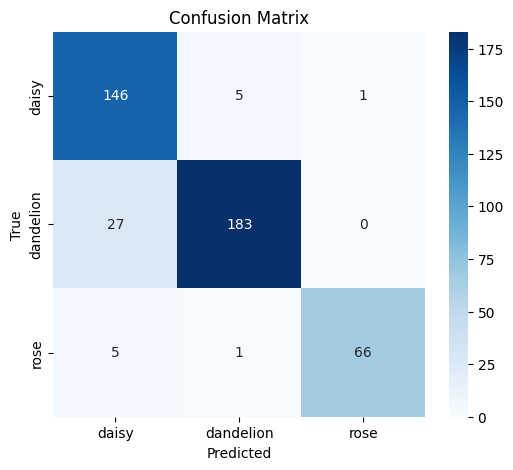

Classification Report:

              precision    recall  f1-score   support

       daisy       0.82      0.96      0.88       152
   dandelion       0.97      0.87      0.92       210
        rose       0.99      0.92      0.95        72

    accuracy                           0.91       434
   macro avg       0.92      0.92      0.92       434
weighted avg       0.92      0.91      0.91       434



In [19]:
# Cell 10 - predictions on validation set (use generator with shuffle=False)
val_generator.reset()
pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes  # integer labels

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(train_generator.class_indices.keys()),
            yticklabels=list(train_generator.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))


Number of misclassified samples in validation: 39


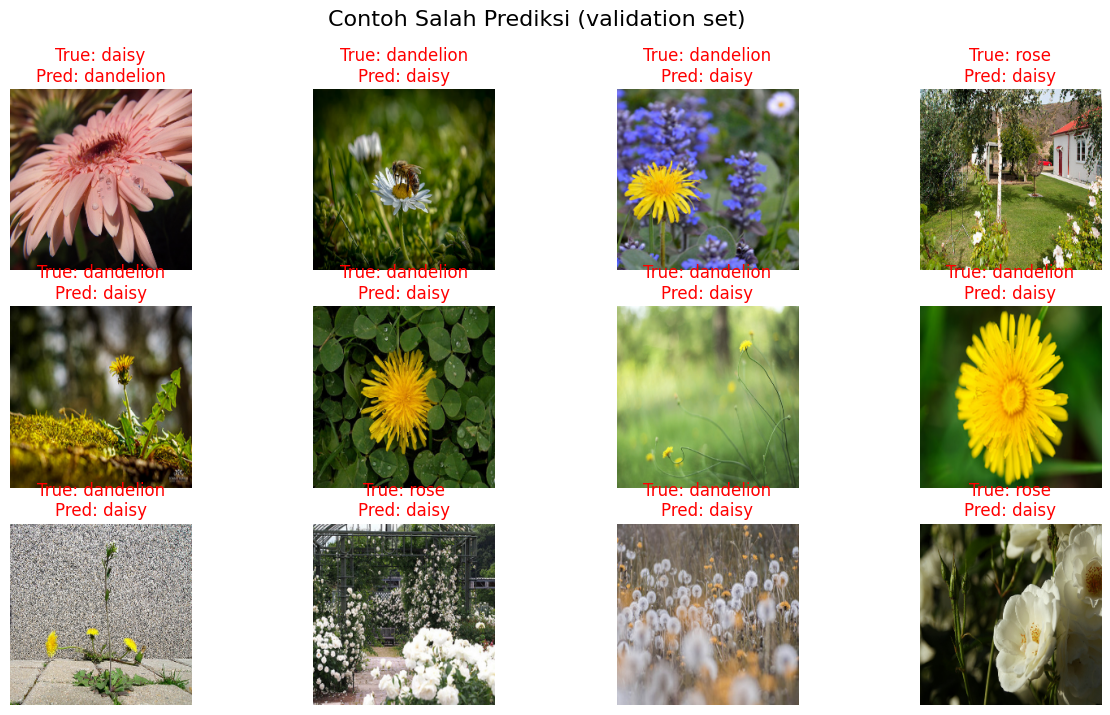

In [20]:
# Cell 11 - show examples of misclassified images
import random
mis_idx = np.where(y_pred != y_true)[0]
print("Number of misclassified samples in validation:", len(mis_idx))

if len(mis_idx) > 0:
    samples = random.sample(list(mis_idx), min(12, len(mis_idx)))
    plt.figure(figsize=(15,8))
    for i, s in enumerate(samples):
        img, label = val_generator[s] if False else None, None  # we won't use this method
        # get filename for sample s from val_generator
        fn = val_generator.filepaths[s]  # full path
        img_arr = plt.imread(fn)
        img_resized = tf.image.resize(img_arr, (IMG_SIZE, IMG_SIZE)).numpy().astype(np.uint8)
        plt.subplot(3,4,i+1)
        plt.imshow(img_resized)
        true_label_name = list(train_generator.class_indices.keys())[y_true[s]]
        pred_label_name = list(train_generator.class_indices.keys())[y_pred[s]]
        plt.title(f"True: {true_label_name}\nPred: {pred_label_name}", color='red')
        plt.axis('off')
    plt.suptitle("Contoh Salah Prediksi (validation set)", fontsize=16)
    plt.show()
else:
    print("No misclassifications found in validation set.")


In [23]:
# tentukan folder tujuan
save_dir = r"C:\Users\ThinkPad\OneDrive\Documents\Portofolio\flower recognition\best_model"
final_path = os.path.join(save_dir, "final_transfer_model.keras")

# simpan model
model.save(final_path)
print(f"Saved final model to {final_path}")


Saved final model to C:\Users\ThinkPad\OneDrive\Documents\Portofolio\flower recognition\best_model\final_transfer_model.keras
